In [87]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [88]:
import scipy.stats as stats
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [89]:
# Read CSV files from data folder and store in dataframes
hackathons = pd.read_csv('../data/hackathons_modified.csv')
projects = pd.read_csv('../data/projects_modified.csv')
participants_expanded = pd.read_csv('../data/participants_expanded_post_inference.csv')

In [90]:
import warnings
warnings.filterwarnings('ignore')

In [91]:
hackathons["year"] = hackathons["start_date_format"].map(
                    lambda x:int(x[:4]))

## The number of hackathons 

In [92]:
len(hackathons["URL"].unique())

7053

In [93]:
hackathons["registered_N"].describe()

count     7053.000000
mean       142.314193
std        432.513814
min          0.000000
25%         24.000000
50%         60.000000
75%        143.000000
max      18701.000000
Name: registered_N, dtype: float64

In [94]:
len(participants_expanded["url"].unique())

56495

In [95]:
len(projects)

192696

In [96]:
hack_num = hackathons[["year","URL"]].groupby(by=["year"]).count()
# Add a constant to the model (intercept term)
hack_num = hack_num.reset_index()
X = sm.add_constant(hack_num['year'])

# Define the dependent variable (Participants)
y = hack_num['URL']

# Perform linear regression
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())

model.pvalues

                            OLS Regression Results                            
Dep. Variable:                    URL   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     52.97
Date:                Mon, 29 Sep 2025   Prob (F-statistic):           9.76e-06
Time:                        22:04:04   Log-Likelihood:                -91.768
No. Observations:                  14   AIC:                             187.5
Df Residuals:                      12   BIC:                             188.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.781e+05   2.45e+04     -7.258      0.0

const    0.00001
year     0.00001
dtype: float64

In [97]:
# Get ANOVA-like values
ss_total = sum((y - y.mean())**2)
ss_regression = sum((model.fittedvalues - y.mean())**2)
ss_residual = sum(model.resid ** 2)

# Compute partial eta squared
eta_sq_partial = ss_regression / (ss_regression + ss_residual)

print(f"Partial η²: {eta_sq_partial:.4f}")


Partial η²: 0.8153


    year  start_date_format
0   2009                  1
1   2010                  6
2   2011                 19
3   2012                 31
4   2013                 99
5   2014                363
6   2015                633
7   2016                711
8   2017                736
9   2018                800
10  2019                865
11  2020                951
12  2021               1212
13  2022                626


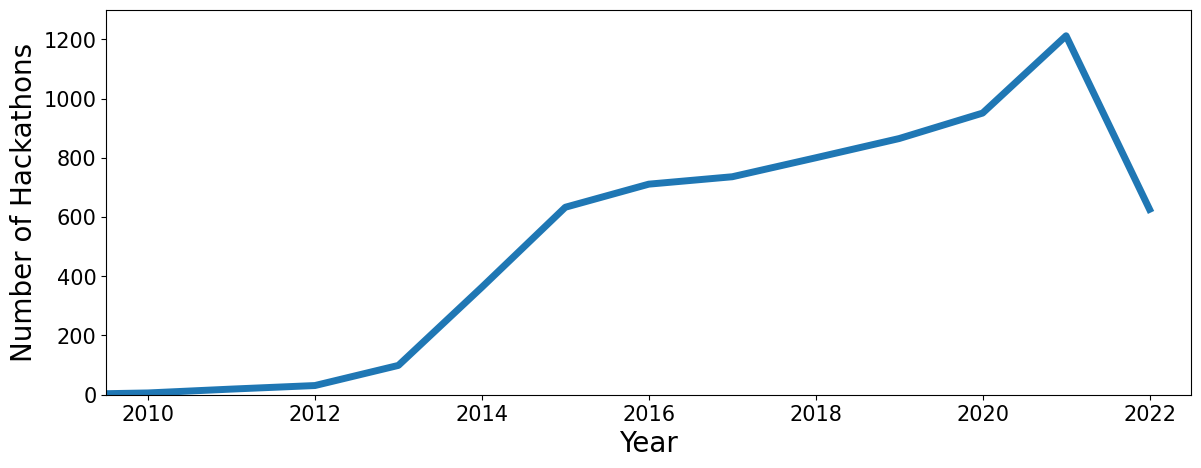

In [98]:
# Plotting
fig, ax = plt.subplots(figsize=(14, 5))  # Set the figure size for better readability
# Assuming 'start_date_format' and 'end_date_format' are already in a suitable format (e.g., YYYY-MM-DD)
hackathons['start_date_format'] = pd.to_datetime(hackathons['start_date_format'])
hackathons["year"] = hackathons["start_date_format"].map(lambda x:x.year)

# Resample to monthly data, count number of hackathons starting each month
hackathon_count = hackathons.groupby(by="year").count()["start_date_format"].reset_index()

print(hackathon_count)

# hackathon_count.plot(kind='line', marker='o', ax=plt.gca())  # 'o' gives us points at each data point

ax.plot(hackathon_count["year"], hackathon_count["start_date_format"],
       linewidth=5)

# plt.title('Yearly Distribution of Hackathons by Participation Type')
plt.xlabel('Year', fontsize=20)
plt.ylabel('Number of Hackathons', fontsize=20)
plt.xlim(left=2009.5, right=2022.5)
plt.ylim(0, 1300)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(False)
# plt.legend(title='Participation Type')
plt.savefig("../results/counts_year.pdf",
           bbox_inches="tight")
plt.show()

## the median number of participants

56495
Gender Distribution in Hackathons:
Gender
m          39617
f          13684
unknown     3194
Name: count, dtype: int64


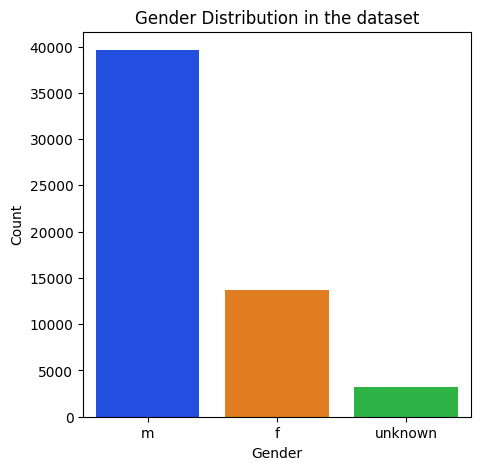

Number of Hackathons by Gender:
Gender
f          3866
m          4900
unknown    1875
Name: hackathons_list, dtype: int64


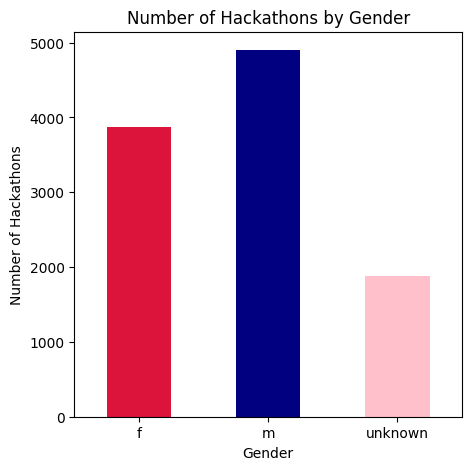

In [99]:
# Ensure the relevant columns are present in the dataset
if 'Gender' in participants_expanded.columns and 'hackathons' in participants_expanded.columns:
    
    # Gender distribution in dataset - calculates the count of each gender in the dataset 
    gender_distribution = participants_expanded['Gender'].value_counts() 
    print(len(participants_expanded))
    print("Gender Distribution in Hackathons:")
    print(gender_distribution)
    
    # Plotting the gender distribution
    plt.figure(figsize=(5, 5))
    sns.countplot(x='Gender', data=participants_expanded, palette='bright')
    plt.title("Gender Distribution in the dataset")
    plt.xlabel("Gender")
    plt.ylabel("Count")
    plt.show()
    
    # Exploding the hackathons column to find the number of hackathons by gender
    participants_expanded['hackathons_list'] = participants_expanded['hackathons'].str.split(',')
    participants_expanded_exploded = participants_expanded.explode('hackathons_list')
    
    # Number of hackathons by gender
    hackathons_by_gender = participants_expanded_exploded.groupby('Gender')['hackathons_list'].nunique()
    print("Number of Hackathons by Gender:")
    print(hackathons_by_gender)
    
    # Plotting the number of hackathons by gender
    plt.figure(figsize=(5, 5))
    hackathons_by_gender.plot(kind='bar', color=['crimson', 'navy', 'pink', 'orange'])
    plt.title("Number of Hackathons by Gender")
    plt.xlabel("Gender")
    plt.ylabel("Number of Hackathons")
    plt.xticks(rotation=0)
    plt.show()

    
else:
    print("The required columns ('Gender' and 'hackathons') are not present in the dataset.")

In [100]:
# Group by hackathon URL and Gender and count unique participants
grouped_counts = participants_expanded_exploded.groupby(['hackathons_list', 'Gender']).size().reset_index(name='count')

# Pivot the counts
pivoted_counts = grouped_counts.pivot(index='hackathons_list', columns='Gender', values='count').fillna(0)

# Rename columns
pivoted_counts = pivoted_counts.rename(columns={'f': 'females_participating', 
                                                'm': 'males_participating',
                                                'unknown': 'unknown_gender_participating'})

# Step 4: Merge with the hackathons DataFrame
hackathons = hackathons.merge(pivoted_counts, left_on='URL', right_index=True, how='left')

# Step 5: Validation (optional)
hackathons['total_participating'] = hackathons[['females_participating', 'males_participating', 'unknown_gender_participating']].sum(axis=1)

hackathons['is_valid'] = hackathons['total_participating'] == hackathons['registered_N']

# Drop the validation columns for the final result
hackathons = hackathons.drop(columns=['total_participating', 'is_valid'])

# Final result
hackathons

,Unnamed: 0,URL,Criteria,schedule,hack_type,info,start_date_format,end_date_format,Prizes,prize_money,...,prize,registered_N,featured,organization_name,winners_announced,submission_gallery_url,start_a_submission_url,females_participating,males_participating,unknown_gender_participating
0,0,https://wirvsvirushackathon.devpost.com/,"Gesellschaftlicher Mehrwert, Innovationsgrad, ...",no schedule,Public,"Mar 29, 2020, Online, Public, Social Good ...",2020-03-20,2020-03-22,"Euer Preis ist Anerkennung und Ehre!, Habt Spa...",no money prize,...,$0,12505,False,Not Specified,False,https://wirvsvirushackathon.devpost.com/projec...,https://wirvsvirushackathon.devpost.com/challe...,193.0,479.0,31.0
1,4,https://theglobalhack.devpost.com/,"Potential impact of the project, Technical exe...",no schedule,Public,"Apr 12, 2020, Online, Public, COVID-19",2020-04-03,2020-04-09,Overall Winner,no money prize,...,€0,6059,False,Not Specified,False,https://theglobalhack.devpost.com/project-gallery,https://theglobalhack.devpost.com/challenges/s...,99.0,239.0,23.0
2,8,https://supernova.devpost.com/,"X Factor and Potential, Technical Competence, ...",no schedule,Public,"Jul 11, 2022, Online, Public, DFINITY Foundati...",2022-05-10,2022-06-22,"SocialFi - 1ST PLACE, SocialFi - 2ND PLACE, So...","$765,000",...,$0,3633,False,DFINITY Foundation,False,https://supernova.devpost.com/project-gallery,https://supernova.devpost.com/challenges/start...,8.0,48.0,1.0
3,12,https://hajjhackathon.devpost.com/,"Design | التصميم, Simpli...",no schedule,Public,"Aug 3, 2018, Jeddah International Exhibition &...",2018-08-01,2018-08-03,1st place: 1 million Saudi Riyal (15% equity i...,"SAR2,000,000",...,SAR0,2935,False,Not Specified,False,https://hajjhackathon.devpost.com/project-gallery,https://hajjhackathon.devpost.com/challenges/s...,116.0,287.0,19.0
4,16,https://chainlinkspring2022.devpost.com/,"User Experience / User Interface, Originality ...",no schedule,Public,"Jun 8, 2022, Online, Public, Chainlink Labs, B...",2022-04-22,2022-05-28,"Chainlink Grand Prize - $40,000, Chainlink NFT...","$1,019,000",...,$0,1481,False,Chainlink Labs,False,https://chainlinkspring2022.devpost.com/projec...,https://chainlinkspring2022.devpost.com/challe...,14.0,70.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7048,7075,https://checkinproject.devpost.com/,biden,no schedule,Public,"Aug 30, 2021, Thái Lan, Public, ACM Monterrey,...",2021-08-30,2021-08-30,cash value,"$1,000",...,$0,1,False,ACM Monterrey,True,https://checkinproject.devpost.com/project-gal...,https://checkinproject.devpost.com/challenges/...,NaN,NaN,NaN
7049,7076,https://fgtfrgf.devpost.com/,"Criteria 1, Criteria 1, criteria",no schedule,Public,"Jul 15, 2021, Online, Public, Dong Trinh LTD, ...",2021-07-15,2021-07-15,"1st place, 2nd place, 3rd place, 4nd","$1,100",...,$0,1,False,Dong Trinh LTD,True,https://fgtfrgf.devpost.com/project-gallery,https://fgtfrgf.devpost.com/challenges/start_a...,NaN,NaN,NaN
7050,7077,https://old-hacks.devpost.com/,TBA,no schedule,Public,"May 7, 2021, Quận 2, Vietnam, Public, Hackers ...",2021-05-07,2021-05-07,TBA,no money prize,...,$0,1,False,Hackers Galore,True,https://old-hacks.devpost.com/project-gallery,https://old-hacks.devpost.com/challenges/start...,NaN,NaN,NaN
7051,7078,https://thailand-champion-13627.devpost.com/,biden,no schedule,Public,"Sep 15, 2021, Thái Lan, Public, Screen Compose...",2021-09-15,2021-09-15,Thailand cash,$100,...,$0,0,False,Screen Composers Guild of Canada & SOCAN,True,https://thailand-champion-13627.devpost.com/pr...,https://thailand-champion-13627.devpost.com/ch...,NaN,NaN,NaN


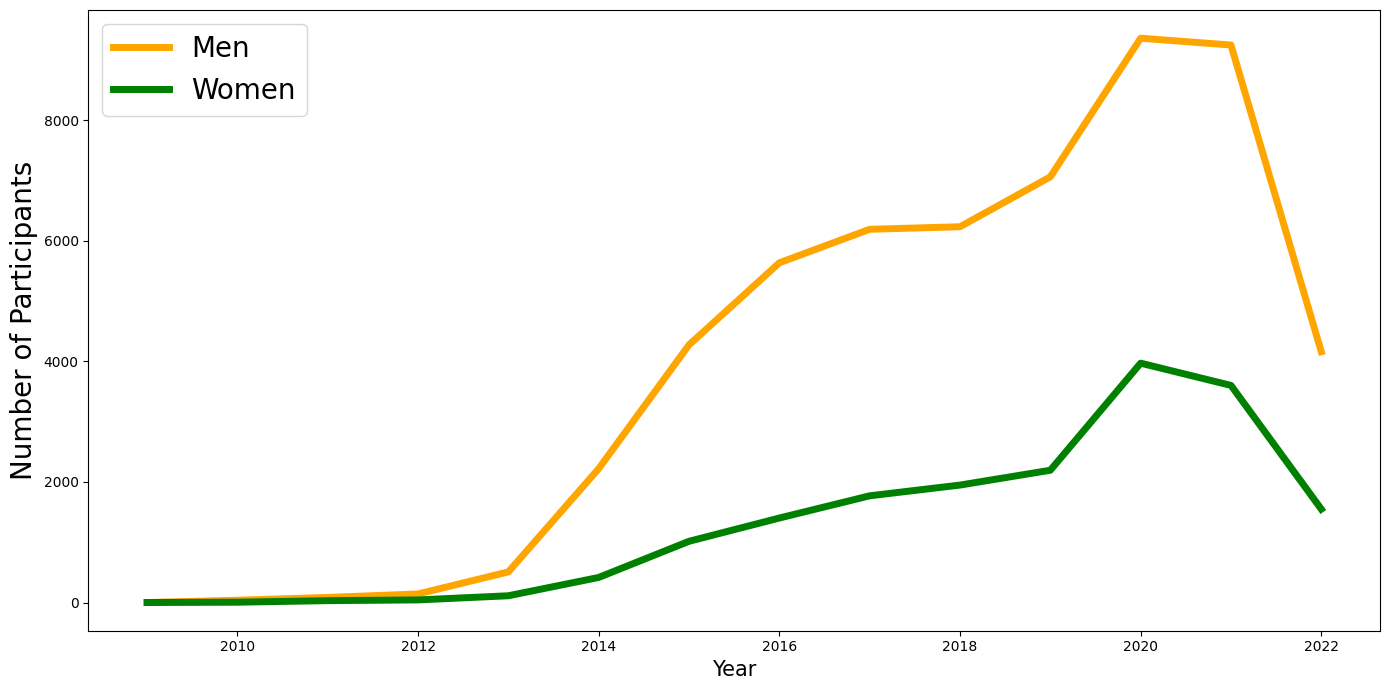

In [117]:
# Ensure start_date_format is in datetime format
# hackathons['start_date_format'] = pd.to_datetime(hackathons['start_date_format'])


# Resample and calculate trends
# ha = hackathons.groupby(by="year")[['males_participating', 'females_participating']].sum().reset_index()
hackathons = hackathons.set_index('year').groupby(by="year")[['males_participating', 'females_participating']].sum().reset_index()

# Plotting the trends
plt.figure(figsize=(14, 7))

# Online trend plot
plt.plot(ha['year'], ha['males_participating'], label='Men', color='orange', linewidth=5)
plt.plot(ha['year'], ha['females_participating'], label='Women', color='green', linewidth=5)
# plt.title('Monthly Women vs. Men Participation', fontsize=20)
plt.xlabel("Year", fontsize=15)
plt.ylabel('Number of Participants', fontsize=20)
plt.legend(fontsize=20)

plt.tight_layout()
plt.savefig("../results/monthly_gender.pdf")
plt.show()

In [15]:
# Creating the actual_participants_N column
hackathons['actual_participants_N'] = (
    hackathons['females_participating'].fillna(0) +
    hackathons['males_participating'].fillna(0) +
    hackathons['unknown_gender_participating'].fillna(0)
)

# Displaying the result
hackathons[['females_participating', 'males_participating',
                 'unknown_gender_participating', 'registered_N',
                 'actual_participants_N', 'URL']]

,females_participating,males_participating,unknown_gender_participating,registered_N,actual_participants_N,URL
0,193.0,479.0,31.0,12505,703.0,https://wirvsvirushackathon.devpost.com/
1,99.0,239.0,23.0,6059,361.0,https://theglobalhack.devpost.com/
2,8.0,48.0,1.0,3633,57.0,https://supernova.devpost.com/
3,116.0,287.0,19.0,2935,422.0,https://hajjhackathon.devpost.com/
4,14.0,70.0,1.0,1481,85.0,https://chainlinkspring2022.devpost.com/
...,...,...,...,...,...,...
7048,NaN,NaN,NaN,1,0.0,https://checkinproject.devpost.com/
7049,NaN,NaN,NaN,1,0.0,https://fgtfrgf.devpost.com/
7050,NaN,NaN,NaN,1,0.0,https://old-hacks.devpost.com/
7051,NaN,NaN,NaN,0,0.0,https://thailand-champion-13627.devpost.com/


In [16]:
# remove 0 actual participants
hackathons = hackathons.loc[hackathons["actual_participants_N"]>0]

In [17]:
len(hackathons["URL"].unique())

5114

    year  actual_participants_N
0   2010               8.600000
1   2011               7.666667
2   2012               8.043478
3   2013              10.560606
4   2014              14.505102
5   2015              13.604534
6   2016              14.046784
7   2017              15.064057
8   2018              15.394415
9   2019              15.668770
10  2020              18.060960
11  2021              15.002232
12  2022              12.840173


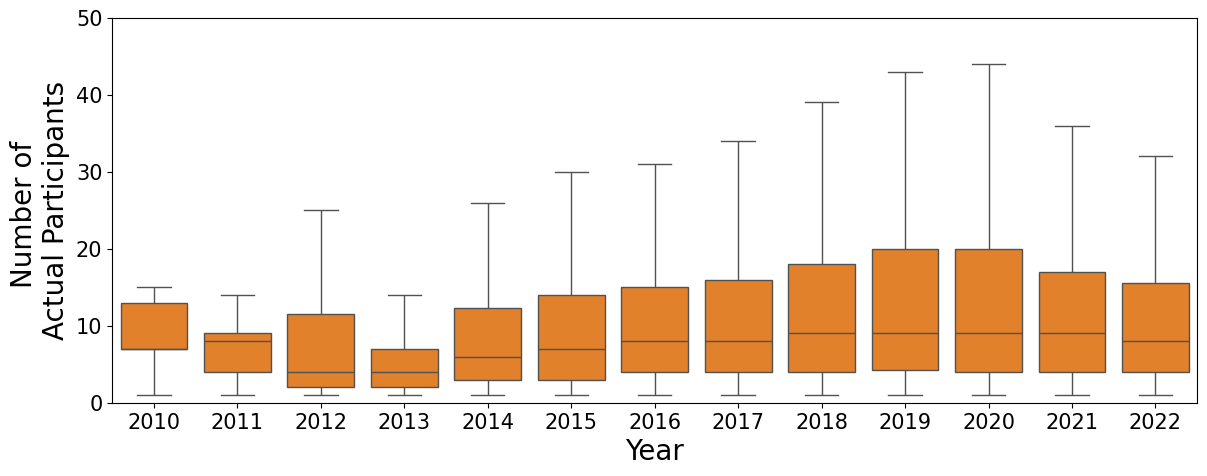

In [18]:
avg_hack_num = hackathons[["year","actual_participants_N"]].groupby(by=["year"]).mean()["actual_participants_N"]

avg_hack_num = avg_hack_num.reset_index()
print(avg_hack_num)

# Visualizing the log-transformed data
fig, axes = plt.subplots(figsize=(14, 5))

sns.boxplot(x=hackathons["year"], y=hackathons["actual_participants_N"], color="tab:orange",
           showfliers=False)


# avg_hack_num.plot(kind='line', marker='o', ax=plt.gca())  # 'o' gives us points at each data point
# plt.title('Yearly Distribution of Hackathons by Participation Type')
plt.xlabel('Year', fontsize=20)
plt.ylabel('Number of \nActual Participants', fontsize=20)
# plt.xlim(left=2009.5, right=2022.5)
plt.ylim(0, 50)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(False)
# plt.legend(title='Participation Type')
plt.savefig("../results/actual_year.pdf",
           bbox_inches="tight")
plt.show()


In [19]:
median_hack_num = hackathons[["year","actual_participants_N"]].groupby(by=["year"]).median()

# Add a constant to the model (intercept term)
median_hack_num = median_hack_num.reset_index()
X = sm.add_constant(median_hack_num['year'])

# Define the dependent variable (Participants)
y = median_hack_num['actual_participants_N']

# Perform linear regression
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())


                              OLS Regression Results                             
Dep. Variable:     actual_participants_N   R-squared:                       0.416
Model:                               OLS   Adj. R-squared:                  0.363
Method:                    Least Squares   F-statistic:                     7.844
Date:                   Sun, 28 Sep 2025   Prob (F-statistic):             0.0173
Time:                           23:48:37   Log-Likelihood:                -21.759
No. Observations:                     13   AIC:                             47.52
Df Residuals:                         11   BIC:                             48.65
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -579.6923 

In [20]:
# Get ANOVA-like values
ss_total = sum((y - y.mean())**2)
ss_regression = sum((model.fittedvalues - y.mean())**2)
ss_residual = sum(model.resid ** 2)

# Compute partial eta squared
eta_sq_partial = ss_regression / (ss_regression + ss_residual)

print(f"Partial η²: {eta_sq_partial:.4f}")


Partial η²: 0.4163


## H1: Number of hackathons participated

In [25]:
# genenrate a new DF that has one participant one hackathon each row
new_parts = []
parts = participants_expanded.fillna("")
for i, row in parts.iterrows():
    for h in row["hackathons"].split(","):
        new_parts.append({
            "url": row["url"],
            "hackathon": h,
            "gender": row["Gender"]
        })
new_parts = pd.DataFrame(new_parts)

In [26]:
# URL is the ID
hack = hackathons[["URL", "year"]]
hack["hackathon"] = hack["URL"]
hack = hack.drop(columns=["URL"])
# add hackathon's information to the DF
new_parts = new_parts.merge(hack, on=["hackathon"])

In [27]:
# separate genders, count the number of hackathons 
men = new_parts.loc[new_parts["gender"]=="m"].groupby(by=["url"])["hackathon"].count().reset_index()
women = new_parts.loc[new_parts["gender"]=="f"].groupby(by=["url"])["hackathon"].count().reset_index()

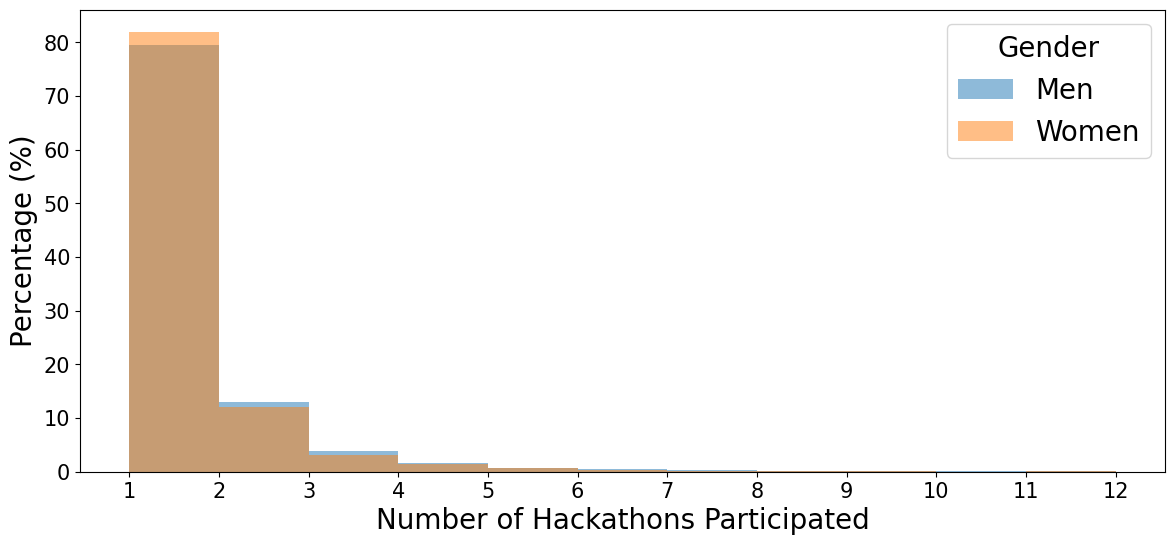

In [28]:
plt.figure(figsize=(14, 6))

gender_dict = ["Men", "Women"]

bin_intervals = range(1, 13)
for i, subset in enumerate([men, women]):    
    # Create weights so each group sums to 1 (i.e., 100% when scaled)
    weights = np.ones_like(subset['hackathon']) / len(subset['hackathon'])
    
    plt.hist(subset['hackathon'], bins=bin_intervals, alpha=0.5,
             weights=weights * 100,  # Scale to percent
             
             label=gender_dict[i])

plt.xlabel("Number of Hackathons Participated", fontsize=20)
plt.ylabel("Percentage (%)", fontsize=20)

plt.xticks(range(1, 13), fontsize=15)
plt.yticks(fontsize=15)
# plt.title("Histogram of Number of Skills by Gender")
plt.legend(title="Gender", fontsize=20,
          title_fontsize=20)
plt.savefig("../results/gender_num_hackathons.pdf")
plt.show()

In [29]:
# see the number of hackathons they participate
men["hackathon"].describe(), women["hackathon"].describe()

(count    39564.000000
 mean         1.394728
 std          1.429913
 min          1.000000
 25%          1.000000
 50%          1.000000
 75%          1.000000
 max         66.000000
 Name: hackathon, dtype: float64,
 count    13659.000000
 mean         1.322498
 std          1.063801
 min          1.000000
 25%          1.000000
 50%          1.000000
 75%          1.000000
 max         30.000000
 Name: hackathon, dtype: float64)

In [30]:
# if the p-value is significant -> not normal
male_normality = stats.shapiro(men["hackathon"])
female_normality = stats.shapiro(women["hackathon"])
print("Shapiro-Wilk Test for Normality:")
print(f"Men p-value: {male_normality.pvalue}")
print(f"Women p-value: {female_normality.pvalue}")

Shapiro-Wilk Test for Normality:
Men p-value: 0.0
Women p-value: 0.0


In [31]:
u_stat, p_value = stats.mannwhitneyu(men["hackathon"], 
                                     women["hackathon"], 
                                     alternative='greater')
print("Mann-Whitney U Test Results:")
print(f"U-statistic: {u_stat}, P-value: {p_value}")

Mann-Whitney U Test Results:
U-statistic: 277324766.5, P-value: 1.902124892954769e-11


In [32]:
def mannwhitney_effect_size_r(group1, group2, alternative='two-sided'):
    """
    Compute the effect size r for a Mann-Whitney U test.

    Parameters:
        group1 (array-like): Sample 1
        group2 (array-like): Sample 2
        alternative (str): 'two-sided', 'greater', or 'less'

    Returns:
        r (float): Effect size r
    """
    u_stat, p_value = stats.mannwhitneyu(group1, group2, alternative=alternative)
    n1, n2 = len(group1), len(group2)
    N = n1 + n2

    # Compute z from U (normal approximation)
    mean_u = n1 * n2 / 2
    std_u = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
    z = (u_stat - mean_u) / std_u

    # Effect size r
    r = z / np.sqrt(N)
    return r, z, u_stat, p_value

In [33]:
mannwhitney_effect_size_r(men["hackathon"], 
                          women["hackathon"])

(0.019941404434218504, 4.600504044785865, 277324766.5, 3.804249785909538e-11)

## H2: Medium number of skills reported by different genders

### Cleaning the skills and interests column

In [34]:
# Define a function to convert the column to a list
def convert_to_list(x):
    if pd.isna(x):
        return []
    return x.split('|')

# Apply the function to the skills and interests columns
participants_expanded['skills'] = participants_expanded['skills'].apply(convert_to_list)
participants_expanded['interests'] = participants_expanded['interests'].apply(convert_to_list)

# Display the updated DataFrame
participants_expanded[['skills', 'interests']]

,skills,interests
0,[],[]
1,"[wordpress, python, tableau, excel, Blockchain, ]","[AR/VR, Blockchain, Communication, Cybersecuri..."
2,"[java, c++, javascript, angular.js, css, html,...","[Beginner Friendly, Blockchain, Cybersecurity,..."
3,"[java, javascript, ]","[Communication, Cybersecurity, Gaming, IoT, Ma..."
4,"[android, javascript, php, java, ios, jquery, ...",[]
...,...,...
56490,"[python, java, react, react-native, firebase, ...","[AR/VR, Blockchain, E-commerce/Retail, Fintech..."
56491,"[mac, web, windows, ]",[]
56492,[],[]
56493,"[web, react, python, flask, html5, websockets,...","[Beginner Friendly, Design, Education, Health,..."


In [38]:
# Explode the skills column to have one skill per row
exploded_skills = participants_expanded.explode('skills')

# Strip any leading or trailing spaces and remove empty strings
exploded_skills['skills'] = exploded_skills['skills'].str.strip()
exploded_skills = exploded_skills[exploded_skills['skills'] != '']
exploded_skills = exploded_skills[exploded_skills['skills'] != ',']

# Count the occurrences of each skill
skill_counts = exploded_skills['skills'].value_counts().reset_index()
skill_counts.columns = ['Skill', 'Count']

# Get the top 20 skills
top_skills = skill_counts.head(20)

# Display the top 20 skills
print("Top 20 Skills of Participants:")
print(top_skills)

Top 20 Skills of Participants:
         Skill  Count
0       python  23910
1         java  21142
2   javascript  17249
3          c++   9995
4        html5   8812
5          css   8472
6            c   6976
7         html   6041
8   Blockchain   5969
9      android   5058
10     node.js   4281
11       react   4208
12          c#   3589
13        css3   3470
14         sql   3299
15         php   3126
16         ios   2954
17      jquery   2618
18   photoshop   2122
19         web   2037


In [39]:
participants_expanded["skills"] = participants_expanded["skills"].fillna("")
participants_expanded["num_skills"] = participants_expanded["skills"].map(
                        lambda x:len(x)-1)

In [40]:
participants_expanded["skills"]

0                                                       []
1        [wordpress, python, tableau, excel, Blockchain, ]
2        [java, c++, javascript, angular.js, css, html,...
3                                     [java, javascript, ]
4        [android, javascript, php, java, ios, jquery, ...
                               ...                        
56490    [python, java, react, react-native, firebase, ...
56491                                [mac, web, windows, ]
56492                                                   []
56493    [web, react, python, flask, html5, websockets,...
56494                            [java, c++, Blockchain, ]
Name: skills, Length: 56495, dtype: object

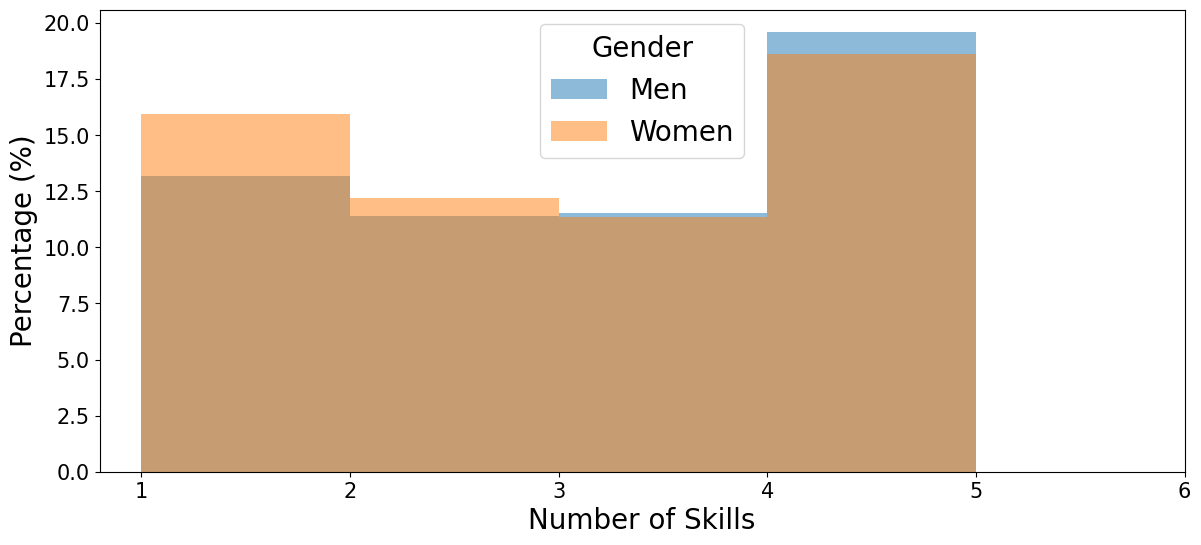

In [49]:
plt.figure(figsize=(14, 6))

gender_dict = {"m": "Men",
              "f": "Women"}

bin_intervals = range(1, 6)
for gender in ["m", "f"]:
    subset = participants_expanded[participants_expanded['Gender'] == gender]
    
    # Create weights so each group sums to 1 (i.e., 100% when scaled)
    weights = np.ones_like(subset['num_skills']) / len(subset['num_skills'])
    
    plt.hist(subset['num_skills'], bins=bin_intervals, alpha=0.5,
             weights=weights * 100,  # Scale to percent
             label=gender_dict[gender])

plt.xlabel("Number of Skills", fontsize=20)
plt.ylabel("Percentage (%)", fontsize=20)

plt.xticks(range(1, ), fontsize=15)
plt.yticks(fontsize=15)
# plt.title("Histogram of Number of Skills by Gender")
plt.legend(title="Gender", fontsize=20,
          title_fontsize=20)
plt.savefig("../results/gender_num_skills.pdf")
plt.show()

In [50]:
c = Counter(subset["num_skills"])

In [59]:
larger_than_12 = sum([c[i] for i in range(13, 32)])
larger_than_12

216

In [60]:
1-216/len(subset)

0.9842151417714119

In [44]:
1-2895/len(subset)

0.7884390529085062

In [46]:
subset.loc[subset["num_skills"]>0]["num_skills"].describe()

count    10789.000000
mean         4.165724
std          3.094508
min          1.000000
25%          2.000000
50%          3.000000
75%          6.000000
max         36.000000
Name: num_skills, dtype: float64

In [217]:
# Subset the data by gender
male_skills = participants_expanded[participants_expanded['Gender'] == 'm']['num_skills']
female_skills = participants_expanded[participants_expanded['Gender'] == 'f']['num_skills']

# Perform Mann-Whitney U Test
u_statistic, p_value = stats.mannwhitneyu(male_skills, 
                                          female_skills,
                                         alternative='greater')

print("Mann-Whitney U Test Statistic:", u_statistic)
print("p-value:", p_value)

Mann-Whitney U Test Statistic: 68639062.0
p-value: 2.236015684488366e-54


In [222]:
male_skills.describe()

count    17829.000000
mean         4.293511
std          3.603895
min         -1.000000
25%          2.000000
50%          4.000000
75%          6.000000
max         65.000000
Name: num_skills, dtype: float64

In [ ]:
female_skills.describe()

In [ ]:
mannwhitney_effect_size_r(male_skills, 
                          female_skills)

## H3: Association between gender and skills

In [ ]:
# Plotting the top 20 skills
plt.figure(figsize=(14, 10))
bars = plt.barh(top_skills['Skill'], top_skills['Count'], color='tab:brown')
plt.xlabel('Count', fontsize=20)
plt.ylabel('Skill', fontsize=20)
plt.yticks(fontsize=15)
plt.xlim(0, 25390)
plt.xticks(fontsize=15)
# plt.title('Top 20 Skills of Participants')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count at the top

# Adding value numbers to the bars
for bar in bars:
    plt.text(bar.get_width() + 100, bar.get_y() + bar.get_height() / 2,
             f'{int(bar.get_width())}', va='center',
            fontsize=14)
plt.savefig("../results/top20skill.pdf", bbox_inches="tight")
plt.show()

In [ ]:
classification = {
    'python': 'PL', 'java': 'PL', 'javascript': 'PL', 'c++': 'PL', 'html5': 'PL', 'css': 'PL', 'c': 'PL',
    'html': 'PL', 'Blockchain': 'TS', 'android': 'TS', 'node.js': 'TS', 'react': 'TS', 'c#': 'PL', 
    'css3': 'TS', 'sql': 'PL', 'php': 'PL', 'ios': 'TS', 'jquery': 'TS', 'photoshop': 'TS', 'web': 'TS',
    'machine-learning': 'TS', 'arduino': 'TS', 'unity': 'PL', 'mysql': 'TS', 'matlab': 'PL', 'mongodb': 'TS',
    'swift': 'PL', 'design': 'TS', 'r': 'PL', 'angular.js': 'TS', 'django': 'TS', 'amazon-web-services': 'TS',
    'bootstrap': 'TS', 'android-studio': 'TS', 'flask': 'TS', 'ruby-on-rails': 'PL', 'linux': 'TS', 
    'express.js': 'TS', 'adobe-illustrator': 'TS', 'git': 'TS', 'firebase': 'TS', 'typescript': 'PL', 
    'react-native': 'TS', 'windows': 'TS', 'hardware': 'TS', 'flutter': 'TS', 'github': 'TS', 'postgresql': 'TS',
    'raspberry-pi': 'TS', 'ruby': 'PL', 'solidity': 'PL', 'pandas': 'TS', 'bash': 'PL', 'jira': 'TS', 
    'scala': 'PL', 'kotlin': 'PL', 'sass': 'TS', 'less': 'TS', 'perl': 'PL', 'objective-c': 'PL', 
    'shell': 'PL', 'vba': 'PL', 'salesforce': 'TS', 'spark': 'TS', 'hadoop': 'TS', 'kubernetes': 'TS', 
    'docker': 'TS', 'ansible': 'TS', 'puppet': 'TS', 'chef': 'TS', 'jenkins': 'TS', 'travis-ci': 'TS', 
    'circleci': 'TS', 'azure': 'TS', 'gcp': 'TS', 'bigquery': 'TS', 'tableau': 'TS', 'power-bi': 'TS', 
    'd3.js': 'TS', 'vue.js': 'TS', 'svelte': 'TS', 'next.js': 'TS', 'nuxt.js': 'TS', 'gatsby': 'TS',
    'redux': 'TS', 'mobx': 'TS', 'ember.js': 'TS', 'backbone.js': 'TS', 'three.js': 'TS', 'webgl': 'TS',
    'tensorflow': 'TS', 'keras': 'TS', 'pytorch': 'TS', 'theano': 'TS', 'mxnet': 'TS', 'opencv': 'TS',
    'nltk': 'TS', 'spacy': 'TS', 'gensim': 'TS', 'beautifulsoup': 'TS', 'scrapy': 'TS', 'selenium': 'TS',
    'robot-framework': 'TS', 'cucumber': 'TS', 'pytest': 'TS', 'unittest': 'TS', 'mocha': 'TS', 'chai': 'TS',
    'jest': 'TS', 'karma': 'TS', 'enzyme': 'TS', 'nightwatch.js': 'TS', 'phantomjs': 'TS', 'protractor': 'TS',
    'cypress': 'TS', 'webdriverio': 'TS', 'testcafe': 'TS', 'grunt': 'TS', 'gulp': 'TS', 'webpack': 'TS',
    'rollup': 'TS', 'parcel': 'TS', 'browserify': 'TS', 'babel': 'TS', 'typescript': 'PL', 'flow': 'TS',
    'eslint': 'TS', 'prettier': 'TS', 'stylelint': 'TS', 'eslint-config-airbnb': 'TS', 'eslint-config-google': 'TS',
    'eslint-plugin-react': 'TS', 'eslint-plugin-jsx-a11y': 'TS', 'eslint-plugin-import': 'TS', 'eslint-plugin-flowtype': 'TS',
    'eslint-plugin-vue': 'TS', 'eslint-plugin-promise': 'TS', 'eslint-plugin-standard': 'TS', 'eslint-plugin-node': 'TS',
    'eslint-plugin-security': 'TS', 'eslint-plugin-compat': 'TS', 'eslint-plugin-functional': 'TS', 'eslint-plugin-optimize-regex': 'TS'
}

# Explode the skills list
participants_expanded_exploded = participants_expanded.explode('skills')

# Apply classification
participants_expanded_exploded['Category'] = participants_expanded_exploded['skills'].apply(
                    lambda x: classification.get(x, 'Other'))

# Create contingency table for gender and skill category
contingency_table = pd.crosstab(participants_expanded_exploded['Gender'], participants_expanded_exploded['Category'])

# Perform Chi-Square test of independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Display the results
print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print('\n')
# Display the observed frequencies table
print("Observed Frequencies Table:")
print(contingency_table)
print('\n')
print("Expected Frequencies Table:")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))
print('\n')
# Interpretation
if p < 0.05:
    print("Reject the null hypothesis. Thus, there is a significant association between gender and skill category.")
else:
    print("Fail to reject the null hypothesis. Thus, there is no significant association between gender and skill category.")

In [ ]:
def cramers_v(confusion_matrix):
    """Compute Cramér's V statistic for categorical-categorical association."""
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.to_numpy().sum()
    min_dim = min(confusion_matrix.shape) - 1
    v = np.sqrt(chi2 / (n * min_dim))
    return v, chi2, p

# Example usage with your data:
contingency_table = pd.crosstab(participants_expanded_exploded['Gender'], participants_expanded_exploded['Category'])

v, chi2, p = cramers_v(contingency_table)

print("Cramér's V:", v)
print("Chi-Square:", chi2)
print("P-value:", p)

In [ ]:
# 1. Explode if skills are lists
participants_expanded_exploded = participants_expanded_exploded.explode('skills')

# 2. Drop NAs just in case
participants_expanded_exploded = participants_expanded_exploded.dropna(subset=['Gender', 'skills'])

# 3. Get top N most frequent skills
top_skills = (
    participants_expanded_exploded['skills']
    .value_counts()
    .head(5)  # ← Change this number for different thresholds
    .index
)

# 4. Filter dataset to only include those top skills
filtered = participants_expanded_exploded[participants_expanded_exploded['skills'].isin(top_skills)]

# 5. Create new contingency table
contingency_top = pd.crosstab(filtered['Gender'], filtered['skills'])

# 6. Run Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_top)

# 7. (Optional) Compute Cramér's V
import numpy as np
n = contingency_top.values.sum()
min_dim = min(contingency_top.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

# 8. Report results
print(f"Chi-square: {chi2:.2f}, p-value: {p:.4g}, dof: {dof}, Cramér's V: {cramers_v:.3f}")


## H4: Number of interests

In [61]:
# participants_expanded["interests"] = participants_expanded["interests"].fillna([])
participants_expanded["num_interests"] = participants_expanded["interests"].map(
                        lambda x:len(x)-1)

In [209]:
len(participants_expanded["interests"].map(str).unique())

11101

In [210]:
len(participants_expanded)

56495

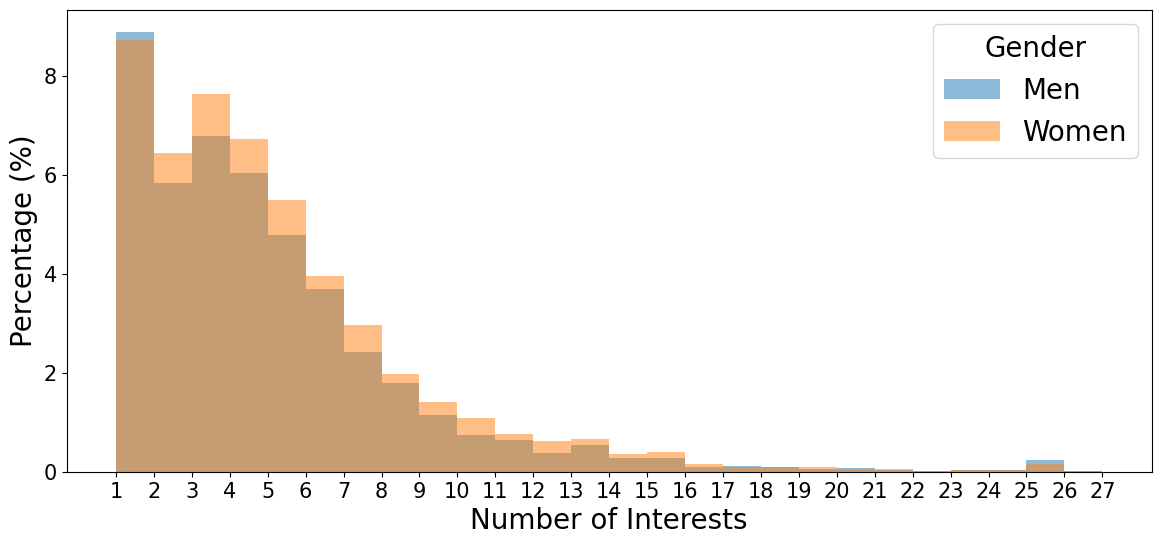

In [66]:
plt.figure(figsize=(14, 6))

gender_dict = {"m": "Men",
              "f": "Women"}

bin_intervals = range(1, 28)
for gender in ["m", "f"]:
    subset = participants_expanded[participants_expanded['Gender'] == gender]
    
    # Create weights so each group sums to 1 (i.e., 100% when scaled)
    weights = np.ones_like(subset['num_interests']) / len(subset['num_interests'])
    
    plt.hist(subset['num_interests'], bins=bin_intervals, alpha=0.5,
             weights=weights * 100,  # Scale to percent
             label=gender_dict[gender])

plt.xlabel("Number of Interests", fontsize=20)
plt.ylabel("Percentage (%)", fontsize=20)

plt.xticks(range(1, 28), fontsize=15)
plt.yticks(fontsize=15)
# plt.title("Histogram of Number of Skills by Gender")
plt.legend(title="Gender", fontsize=20,
          title_fontsize=20)
plt.savefig("../results/gender_num_interests.pdf")
plt.show()

In [67]:
subset.loc[subset["num_interests"]>0]["num_interests"].describe()

count    6836.000000
mean        4.677589
std         3.655210
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        27.000000
Name: num_interests, dtype: float64

In [68]:
Counter(subset["num_interests"])

Counter({-1: 6848,
         11: 105,
         1: 1192,
         13: 90,
         7: 405,
         10: 148,
         5: 752,
         2: 882,
         3: 1043,
         4: 919,
         9: 194,
         6: 540,
         12: 86,
         14: 49,
         8: 270,
         21: 7,
         15: 54,
         19: 12,
         25: 20,
         17: 13,
         22: 2,
         24: 5,
         16: 22,
         20: 7,
         18: 12,
         23: 4,
         27: 3})

In [69]:
1-6848/len(subset)

0.4995615317158726

In [211]:
# Subset the data by gender
participants_expanded = participants_expanded.loc[participants_expanded["num_interests"]>0]
male_interests = participants_expanded[participants_expanded['Gender'] == 'm']['num_interests']
female_interests = participants_expanded[participants_expanded['Gender'] == 'f']['num_interests']

# Perform Mann-Whitney U Test
u_statistic, p_value = stats.mannwhitneyu(male_interests, 
                                          female_interests,
                                         alternative='greater')

print("Mann-Whitney U Test Statistic:", u_statistic)
print("p-value:", p_value)

Mann-Whitney U Test Statistic: 58774295.5
p-value: 0.9999935952080236


In [212]:
male_interests.describe()

count    17829.000000
mean         4.506703
std          3.691722
min          1.000000
25%          2.000000
50%          4.000000
75%          6.000000
max         27.000000
Name: num_interests, dtype: float64

In [213]:
female_interests.describe()

count    6836.000000
mean        4.677589
std         3.655210
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        27.000000
Name: num_interests, dtype: float64

## H5: Association between interests and gender

In [81]:
participants_expanded_exploded = participants_expanded.explode('interests')

# Create contingency table for gender and skill category
contingency_table = pd.crosstab(participants_expanded_exploded['Gender'], participants_expanded_exploded['interests'])

# Perform Chi-Square test of independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Display the results
print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print('\n')
# Display the observed frequencies table
print("Observed Frequencies Table:")
print(contingency_table)
print('\n')
print("Expected Frequencies Table:")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))
print('\n')
# Interpretation
if p < 0.05:
    print("Reject the null hypothesis. Thus, there is a significant association between gender and interest category.")
else:
    print("Fail to reject the null hypothesis. Thus, there is no significant association between gender and interest category.")

Chi-Square Statistic: 1787.011125310408
P-value: 0.0
Degrees of Freedom: 54


Observed Frequencies Table:
interests         AR/VR  Beginner Friendly  Blockchain  Communication  \
Gender                                                                  
f           6836   1518               1295        1074           2080   
m          17829   4202               2564        4616           4062   
unknown     1205    254                176         279            276   

interests  Cybersecurity  Databases  Design  DevOps  E-commerce/Retail  ...  \
Gender                                                                  ...   
f                   1439         27    1281    1006                392  ...   
m                   4262         55    2217    3592                969  ...   
unknown              304          5     154     232                 63  ...   

interests  Machine Learning/AI  Mobile  Music/Art  Open Ended  Productivity  \
Gender                                               

In [82]:
def cramers_v(confusion_matrix):
    """Compute Cramér's V statistic for categorical-categorical association."""
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.to_numpy().sum()
    min_dim = min(confusion_matrix.shape) - 1
    v = np.sqrt(chi2 / (n * min_dim))
    return v, chi2, p

# Example usage with your data:
contingency_table = pd.crosstab(participants_expanded_exploded['Gender'], participants_expanded_exploded['interests'])

v, chi2, p = cramers_v(contingency_table)

print("Cramér's V:", v)
print("Chi-Square:", chi2)
print("P-value:", p)

Cramér's V: 0.0789330550870737
Chi-Square: 1787.011125310408
P-value: 0.0
